# Starter pack

This notebook shows:

- how to load samples from PASTIS using the dataloaders provided in the repository.
- how to visualize the images
- compute the challenge metric
- make a random submission
- explain how your submissions will be processed automatically


In [1]:
# Fill these file paths with the locations on your machine.
# PATH_TO_CODE = "/Users/louis.stefanuto.c/Documents/pastis-benchmark-mines2024/baseline/"
PATH_TO_DATA = "/Users/louis.stefanuto.c/Documents/pastis-benchmark-mines2024/TRAIN"

The data folder should have this hierarchy:

```
.
├── TRAIN/
│   ├── DATA_S2/
│   │   ├── S2_10000.npy
│   │   ├── S2_10001.npy
│   │   ├── S2_10002.npy
│   │   └── ...
│   ├── ANNOTATIONS/
│   │   ├── TARGET_10000.npy
│   │   ├── TARGET_10001.npy
│   │   ├── TARGET_10002.npy
│   │   └── ...
│   └── metadata.json
└── TEST/
    ├── DATA_S2
    │   └── ...
    └── metadata.json
```


# GeoJson


The geojson file contains all the metadata about the patch sequences (id, dates of the sentinel 2 images, geometry of the parcels ...)

- ID: unique id of the patch
- N_Parcel: nb of parcels in the patch
- Parcel_Cover: % of the patch covered by land
- region: the patches are sampled from various regions, we added this information if you want to apply region-based normalization/transformations ...
- dates-S2: dates of the images in the sequence for this patch
- geometry: multipolygon shape telling where the parcels are


In [2]:
from pathlib import Path
import geopandas as gpd

METADATA = Path(PATH_TO_DATA) / "metadata.geojson"

mtd = gpd.read_file(METADATA)
mtd

,ID,region,N_Parcel,Parcel_Cover,dates-S2,geometry
0,10000,0,119,0.808032,"{'0': 20180924, '1': 20180929, '2': 20181004, ...","MULTIPOLYGON (((391504.736 6956805.915, 392781..."
1,10001,0,111,0.501986,"{'0': 20180924, '1': 20180929, '2': 20181004, ...","MULTIPOLYGON (((367628.562 6880296.822, 368905..."
2,10002,0,131,0.638722,"{'0': 20180924, '1': 20180929, '2': 20181004, ...","MULTIPOLYGON (((388950.375 6957003.181, 390227..."
3,10003,0,75,0.866824,"{'0': 20180924, '1': 20180929, '2': 20181004, ...","MULTIPOLYGON (((455228.326 6917189.740, 456504..."
4,10004,0,46,0.204906,"{'0': 20180924, '1': 20180929, '2': 20181004, ...","MULTIPOLYGON (((364779.509 6910052.243, 366056..."
...,...,...,...,...,...,...
1954,11954,3,412,0.593129,"{'0': 20180917, '1': 20180922, '2': 20180927, ...","MULTIPOLYGON (((1025974.352 6842342.142, 10272..."
1955,11955,3,120,0.802946,"{'0': 20180917, '1': 20180922, '2': 20180927, ...","MULTIPOLYGON (((1036872.407 6850881.525, 10381..."
1956,11956,3,33,0.783991,"{'0': 20180917, '1': 20180922, '2': 20180927, ...","MULTIPOLYGON (((977680.878 6836058.796, 978956..."
1957,11957,3,24,0.129896,"{'0': 20180917, '1': 20180922, '2': 20180927, ...","MULTIPOLYGON (((1018204.400 6759608.309, 10194..."


## Sentinel images - Loading and viz


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import pandas as pd


cm = matplotlib.colormaps.get_cmap("tab20")
def_colors = cm.colors
cus_colors = ["k"] + [def_colors[i] for i in range(1, 20)] + ["w"]
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)


def get_rgb(x, batch_index=0, t_show=1):
    """
    Utility function to get a displayable rgb image
    from a Sentinel-2 time series.
    """
    im = x["S2"][batch_index, t_show, [2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [6]:
from baseline.dataset import BaselineDataset
from baseline.collate import pad_collate

# Set seeds for PyTorch and numpy
torch.manual_seed(1234)
np.random.seed(1234)

dt = BaselineDataset(PATH_TO_DATA)

dl = torch.utils.data.DataLoader(
    dt, batch_size=32, collate_fn=pad_collate, shuffle=True
)

Reading patch metadata ...
Done.
Dataset ready.


Let's query a batch from the dataloader:


In [8]:
x, y = dl.__iter__().__next__()

Each batch is made of:

- an **image tensor** of shape $(B, T, C, H, W)$, where:
  - $B$ is the batch size
  - $T$ is the temporal length of the image time series
  - $(C, H, W)$ is the dimension of the patches, channel first
- a **label tensor** of shape $(B, H, W)$, the semantic segmentation ground truth mask.


In [9]:
print(x["S2"].shape)
print(y.shape)

torch.Size([32, 61, 10, 128, 128])
torch.Size([32, 128, 128])


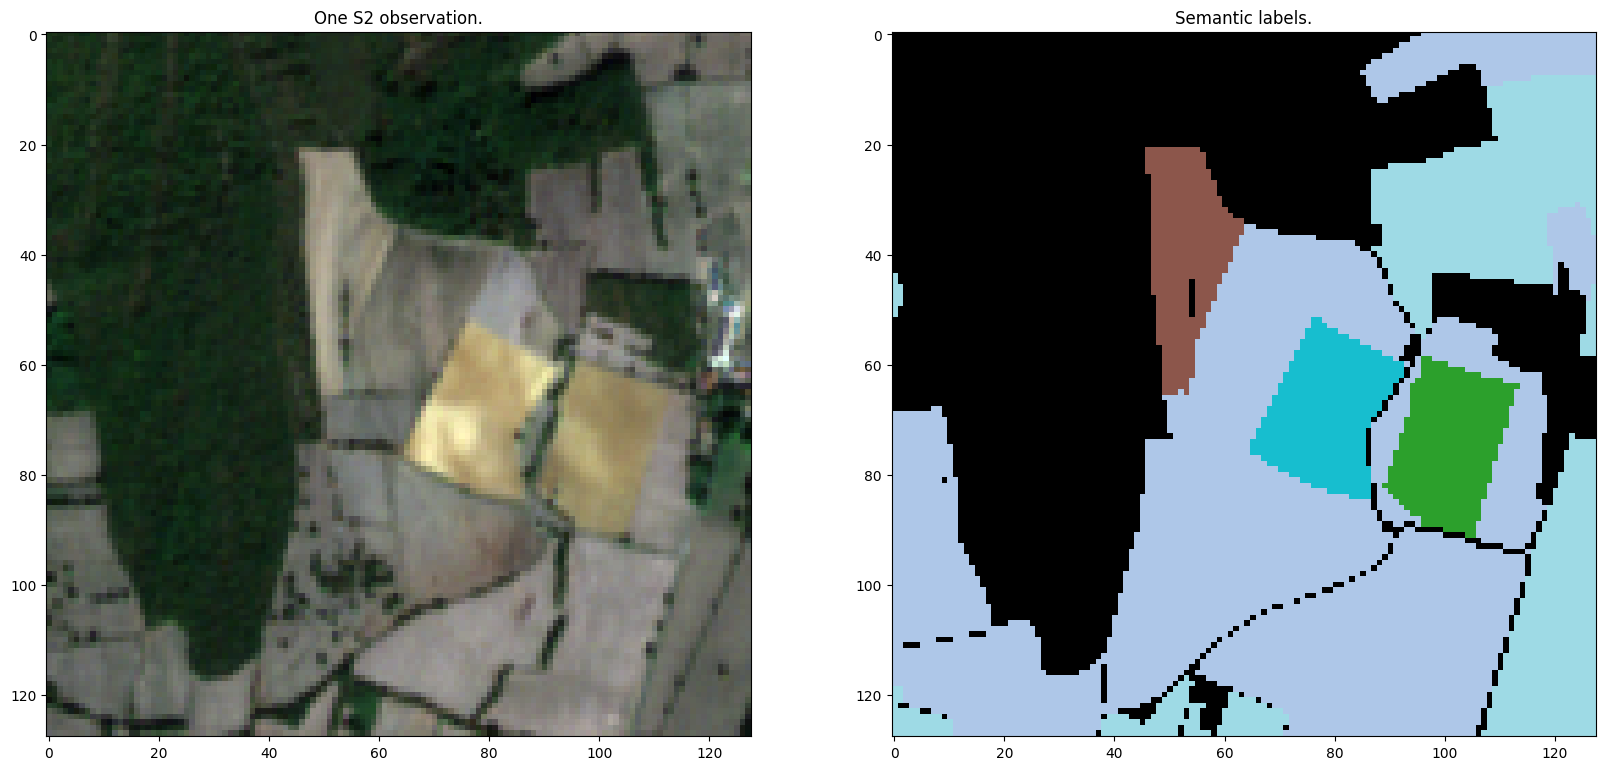

In [10]:
bid = 0  # Which patch of the batch to plot, in [0, BATCHSIZE-1]

fix, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title("One S2 observation.")
axes[1].set_title("Semantic labels.")

plt.show()

## Metrics

The challenge metric is the mean Intersection over Union.

- For each class, compute the binary IoU
- Average the IoUs (`average="macro"`)

We use the sklearn `jaccard_score` function for all the evaluation tasks (see later).


In [14]:
from sklearn.metrics import jaccard_score

NUM_CLASSES = 20
BATCH_SHAPE = (32, 128, 128)

np.random.seed(1234)  # for replicable results

# Create two randoms matrices, one for the preds, one for the targets
preds = np.random.randint(low=0, high=NUM_CLASSES, size=BATCH_SHAPE)

miou = jaccard_score(y.flatten(), preds.flatten(), average="macro")
print("miou:", miou)

miou: 0.015287044536859418


## Submission

This section shows you how to submit predictions on Kaggle.

Your submission must be in the CSV format. It should have two columns:

- **ID**: the ID of the image
- **MASKS**: contains the 1D-flattened string conversion of the 2D segmentation masks

To generate the `MASKS` column, we provide you a `masks_to_str` function. We also provide the decoding script so you have a plain understanding of how we will process your submission.


In [15]:
from baseline.submission_tools import decode_masks, masks_to_str

- Generate a random submission (and solution)

> Note: 474 is the size of the test set


In [16]:
# Set the random seed
np.random.seed(1234)

X = np.random.randint(0, NUM_CLASSES, size=(474, 128, 128), dtype=np.uint8)
masks = masks_to_str(X)
print(X.shape)

submission = pd.DataFrame.from_dict({"ID": range(len(X)), "MASKS": masks})
submission["ID"] = submission["ID"] + 20000

# Note that the index=False argument is important.
submission.to_csv("submission_random.csv", index=False)

(474, 128, 128)


Finally, note that the test set is splitted into two subsets: a public set (50%) and a private set (50%).

During the competition, your scores will be computed **only on the public score**.

At the end of the competition, your scores will be updated to take with your score on the private set into account. The goal is to avoid indirect overfitting on the test set via repeated submissions. This will also add some suspense at the end of the challenge 😇.


## Evaluation pipeline

(Useless for predictions but may be useful if you have issues when submitting)

Here is a short review of how our automated pipeline evaluates your predictions against the test ground truths:


In [17]:
df = pd.read_csv("submission_random.csv")

# Verify the shape of the restored array
X_restored = decode_masks(df["MASKS"].to_list())
print(X_restored.shape)

(474, 128, 128)


Let's check that the restored submission batch is the same as the one you submitted.


In [18]:
# Reconstruction test - Should be True
(X == X_restored).all()

True

Let's compute the mIOU between the original prediction batch tensor and its restored version.

If everything went well, the cell should return `1.0`.


In [19]:
miou = jaccard_score(X.flatten(), X_restored.flatten(), average="macro")
print("miou:", miou)

miou: 1.0


Finally, here is the evaluation pipeline in Kaggle. It incorporates all the aforementioned elements. Note that Kaggle opens your CSV with Pandas before the `score` function. It expects the `ID` column to be the first one of your CSV.


In [28]:
"""
TODO: Enter any documentation that only people updating the metric should read here.

All columns of the solution and submission dataframes are passed to your metric, except for the Usage column.

Your metric must satisfy the following constraints:
- You must have a function named score. Kaggle's evaluation system will call that function.
- You can add your own arguments to score, but you cannot change the first three (solution, submission, and row_id_column_name).
- All arguments for score must have type annotations.
- score must return a single, finite, non-null float.
"""

import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import jaccard_score


class ParticipantVisibleError(Exception):
    # If you want an error message to be shown to participants, you must raise the error as a ParticipantVisibleError
    # All other errors will only be shown to the competition host. This helps prevent unintentional leakage of solution data.
    pass


def decode_masks(
    masks: list[str],
    target_shape: tuple[int, int] = (128, 128),
) -> np.ndarray:
    """
    Convert each string in masks back to a 1D list of integers.

    Args:
        masks (list[str]): list of stringified masks

    Returns:
        np.ndarray: reconstructed batch of masks
    """
    return np.array(
        [
            np.fromstring(mask, sep=" ", dtype=np.uint8).reshape(target_shape)
            for mask in masks
        ]
    )


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str
) -> float:
    """
    Scoring function. Takes the solution and submission and returns the mIOU.
    """
    # Check submission files
    COL_MASK = "MASKS"
    expected_columns = ["ID", COL_MASK]
    for col in expected_columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(
                f"Required column: {col} not found in the submission dataframe. Check your column names."
            )

    if not pandas.api.types.is_string_dtype(submission[COL_MASK]):
        raise ParticipantVisibleError(
            f"Submission column {col} must be an object (str) column."
        )

    # Parse and decode the masks into tensors
    masks_submission = decode_masks(submission[COL_MASK].to_list())
    masks_solution = decode_masks(solution[COL_MASK].to_list())

    if not masks_submission.shape == masks_solution.shape:
        raise ParticipantVisibleError(
            f"Submission should be of shape {masks_solution.shape} after decoding. Got submission.shape: {masks_submission.shape}."
        )

    return jaccard_score(
        y_true=masks_solution.flatten(),
        y_pred=masks_submission.flatten(),
        average="macro",
    )